### Memory_map

### mmap
通过调用memory map，我们让操作系统把文件的内容映射到内存，对内存的读写将关联到对应的文件。而应用通过访问用户空间操作这部分内存，避免了内存拷贝操作。
对于内存映射，有些地方容易被误解，这里说明一下。

### 内存映射是文件到内存空间的映射

对于应用来说，和文件建立映射关系的是虚拟地址空间，而不是物理内存或者Heap。当我们建立一个2g大小的映射时，并不是在heap，更不是在物理内存中分配了这么大的空间，仅仅是在虚拟地址空间中划出了这么大一个区域而已。

应用访问内存映射区域时，操作系统会把虚拟的地址映射成真正的物理内存地址和底层文件的偏移量。如果应用访问的虚拟地址对应的文件内容尚未被装入内存，操作系统通过缺页中断，将内存中的部分内容交换出去，腾出空间将文件的内容读取到内存。

### 内存映射对性能的提升是有条件的
通过内存映射访问文件，虽然减少了内存拷贝，减少了系统调用引起的进程模式切换，但是过程中需要承担缺页中断的负担。

### mmap及其相关系统调用
mmap()系统调用使得进城之间通过映射同一个普通文件实现共享内存。普通文件被映射到进程地址空间后，进程可以像访问普通内存一样对文件进行访问，不必再调用read,write等操作。

mmap()系统调用形式如下：

In [ ]:
#include <sys/mman.h>

void* mmap(void* addr, size_t length, int prot, int flags, int fd, off_t offset);

各参数的含义如下：

    void *addr: 指定映射区域的首选起始地址。如果传递NULL系统将选择一个合适的地址。
    size_t length: 映射区域的长度。这个长度是以字节为单位的，必须大于0。
    int prot: 指定期望的内存保护级别。它是以下几个常量的或运算.
        PROT_READ: 映射区域可被读取。
        PROT_WRITE: 映射区域可被写入。
        PROT_EXEC: 映射区域可执行代码。
        PROT_NONE: 映射区域不能被访问。
    int flags: 控制映射对象的特性。常用的标志包括：
        MAP_SHARED: 对映射区域的修改会反映到文件上，并且对其他映射了同一文件的进程可见。
        MAP_PRIVATE: 所有的修改都只有调用进程可见，不会反映到文件上。
        MAP_FIXED: 如果addr参数非NULL，则映射区域必须从addr开始，否则mmap调用失败。
    int fd: 被映射对象的文件描述符。如果映射不是基于文件的，可能需要设置为-1。
    off_t offset: 文件中的偏移量，它应该是系统页面大小的整数倍。
    
mmap调用成功时，返回指向映射区域的指针。失败时，返回MAP_FAILED（通常是(void *)-1），并设置errno以指示错误原因。
对于小文件的读取，或者对于append模式的文件读写，内存映射的性能未必优于普通io操作。只有对大文件的随机访问，内存映射才可能有明显优势，不过这仍然需要更具体的分析和进一步的benchmark测试。
mmap的作用是映射文件描述符和指定文件的(off_t off)区域至调用进程的(addr,addr *len)的内存区域，如下图所示：

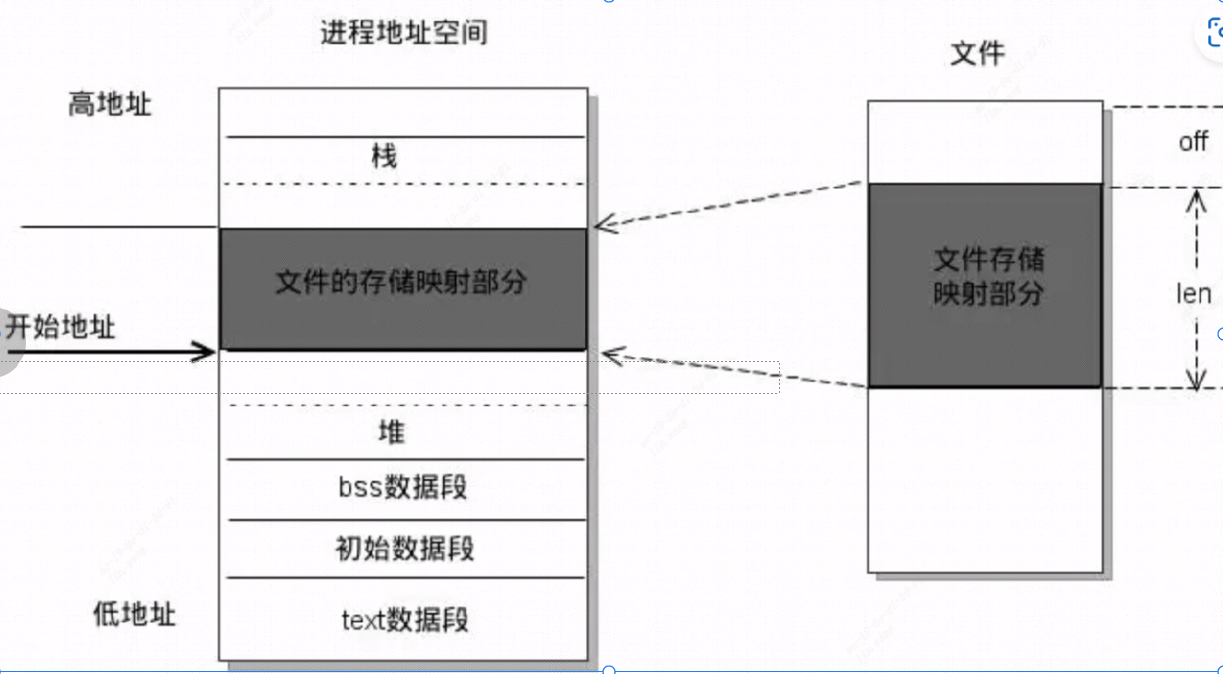

函数的返回值为最后文件映射到进程空间的地址，进程可直接操作起始地址为该值的有效地址。